In [1]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.1', '1.2.1')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Dataset & Dataloader 

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('data/train/', transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder('data/test/', transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [10]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [11]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config 

In [14]:
from jcopdl.layers import conv_block, linear_block

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation='lsoftmax')
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x
    
        
    

In [18]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

# Training Preparation -> MCOC

In [19]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir='model')

# Training 

In [20]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.04it/s]



Epoch     1
Train_cost  = 0.6930 | Test_cost  = 0.6922 | Train_score = 0.5000 | Test_score = 0.5000 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.55it/s]



Epoch     2
Train_cost  = 0.6914 | Test_cost  = 0.6907 | Train_score = 0.5010 | Test_score = 0.5875 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.35it/s]



Epoch     3
Train_cost  = 0.6905 | Test_cost  = 0.6891 | Train_score = 0.5820 | Test_score = 0.5400 |
==> EarlyStop patience =  1 | Best test_score: 0.5875


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.41it/s]



Epoch     4
Train_cost  = 0.6887 | Test_cost  = 0.6871 | Train_score = 0.5530 | Test_score = 0.5450 |
==> EarlyStop patience =  2 | Best test_score: 0.5875


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.42it/s]



Epoch     5
Train_cost  = 0.6866 | Test_cost  = 0.6842 | Train_score = 0.5680 | Test_score = 0.6025 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.60it/s]



Epoch     6
Train_cost  = 0.6835 | Test_cost  = 0.6802 | Train_score = 0.6480 | Test_score = 0.7000 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.24it/s]



Epoch     7
Train_cost  = 0.6787 | Test_cost  = 0.6744 | Train_score = 0.6730 | Test_score = 0.6475 |
==> EarlyStop patience =  1 | Best test_score: 0.7000


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.29it/s]



Epoch     8
Train_cost  = 0.6719 | Test_cost  = 0.6650 | Train_score = 0.6520 | Test_score = 0.7075 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.34it/s]



Epoch     9
Train_cost  = 0.6618 | Test_cost  = 0.6515 | Train_score = 0.7290 | Test_score = 0.7075 |
==> EarlyStop patience =  1 | Best test_score: 0.7075


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.30it/s]



Epoch    10
Train_cost  = 0.6480 | Test_cost  = 0.6332 | Train_score = 0.6980 | Test_score = 0.7125 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.57it/s]



Epoch    11
Train_cost  = 0.6283 | Test_cost  = 0.6098 | Train_score = 0.7230 | Test_score = 0.7150 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.43it/s]



Epoch    12
Train_cost  = 0.6000 | Test_cost  = 0.5849 | Train_score = 0.7250 | Test_score = 0.7175 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.62it/s]



Epoch    13
Train_cost  = 0.5783 | Test_cost  = 0.5610 | Train_score = 0.7260 | Test_score = 0.7375 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.40it/s]



Epoch    14
Train_cost  = 0.5563 | Test_cost  = 0.5421 | Train_score = 0.7430 | Test_score = 0.7475 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.47it/s]



Epoch    15
Train_cost  = 0.5414 | Test_cost  = 0.5242 | Train_score = 0.7460 | Test_score = 0.7600 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.35it/s]



Epoch    16
Train_cost  = 0.5268 | Test_cost  = 0.5116 | Train_score = 0.7510 | Test_score = 0.7525 |
==> EarlyStop patience =  1 | Best test_score: 0.7600


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.39it/s]



Epoch    17
Train_cost  = 0.5141 | Test_cost  = 0.4947 | Train_score = 0.7470 | Test_score = 0.7900 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.58it/s]



Epoch    18
Train_cost  = 0.5110 | Test_cost  = 0.4829 | Train_score = 0.7460 | Test_score = 0.8050 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.58it/s]



Epoch    19
Train_cost  = 0.4919 | Test_cost  = 0.4681 | Train_score = 0.7610 | Test_score = 0.7975 |
==> EarlyStop patience =  1 | Best test_score: 0.8050


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.27it/s]



Epoch    20
Train_cost  = 0.4808 | Test_cost  = 0.4622 | Train_score = 0.7670 | Test_score = 0.8100 |


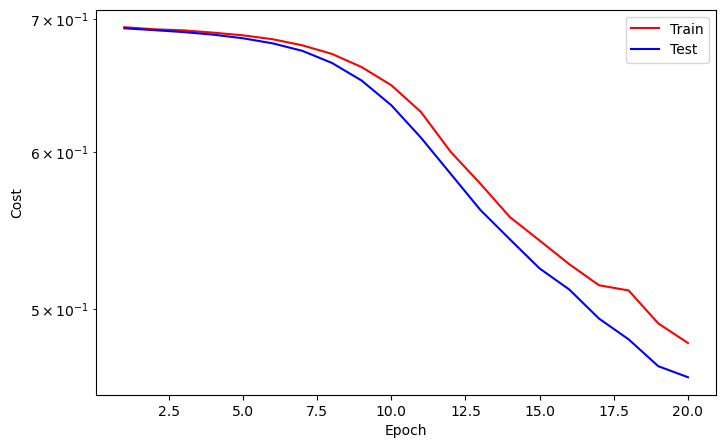

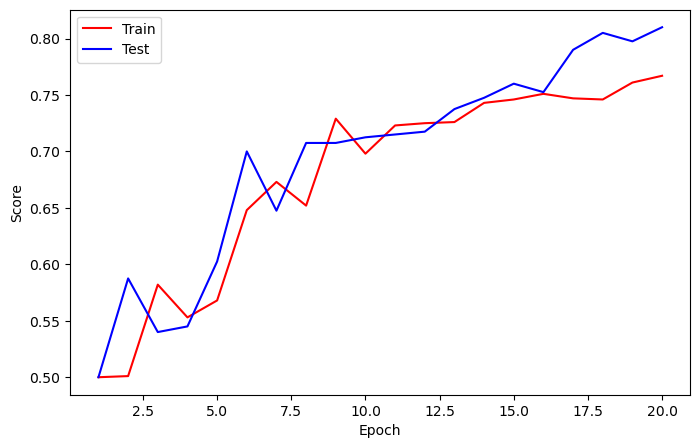

Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.13it/s]



Epoch    21
Train_cost  = 0.4792 | Test_cost  = 0.4599 | Train_score = 0.7810 | Test_score = 0.7825 |
==> EarlyStop patience =  1 | Best test_score: 0.8100


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.29it/s]



Epoch    22
Train_cost  = 0.4721 | Test_cost  = 0.4467 | Train_score = 0.7860 | Test_score = 0.8000 |
==> EarlyStop patience =  2 | Best test_score: 0.8100


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.23it/s]



Epoch    23
Train_cost  = 0.4585 | Test_cost  = 0.4320 | Train_score = 0.7930 | Test_score = 0.8125 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.10it/s]



Epoch    24
Train_cost  = 0.4543 | Test_cost  = 0.4317 | Train_score = 0.7930 | Test_score = 0.8075 |
==> EarlyStop patience =  1 | Best test_score: 0.8125


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  4.00it/s]



Epoch    25
Train_cost  = 0.4545 | Test_cost  = 0.4209 | Train_score = 0.7940 | Test_score = 0.8250 |


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.50it/s]



Epoch    26
Train_cost  = 0.4491 | Test_cost  = 0.4224 | Train_score = 0.7830 | Test_score = 0.8175 |
==> EarlyStop patience =  1 | Best test_score: 0.8250


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.30it/s]



Epoch    27
Train_cost  = 0.4449 | Test_cost  = 0.4687 | Train_score = 0.7930 | Test_score = 0.7575 |
==> EarlyStop patience =  2 | Best test_score: 0.8250


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45it/s]



Epoch    28
Train_cost  = 0.4498 | Test_cost  = 0.4274 | Train_score = 0.7760 | Test_score = 0.8225 |
==> EarlyStop patience =  3 | Best test_score: 0.8250


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38it/s]



Epoch    29
Train_cost  = 0.4298 | Test_cost  = 0.4137 | Train_score = 0.8100 | Test_score = 0.8200 |
==> EarlyStop patience =  4 | Best test_score: 0.8250


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.26it/s]



Epoch    30
Train_cost  = 0.4362 | Test_cost  = 0.4102 | Train_score = 0.8020 | Test_score = 0.8150 |
==> EarlyStop patience =  5 | Best test_score: 0.8250
==> Execute Early Stopping at epoch: 30 | Best test_score: 0.8250
==> Best model is saved at model


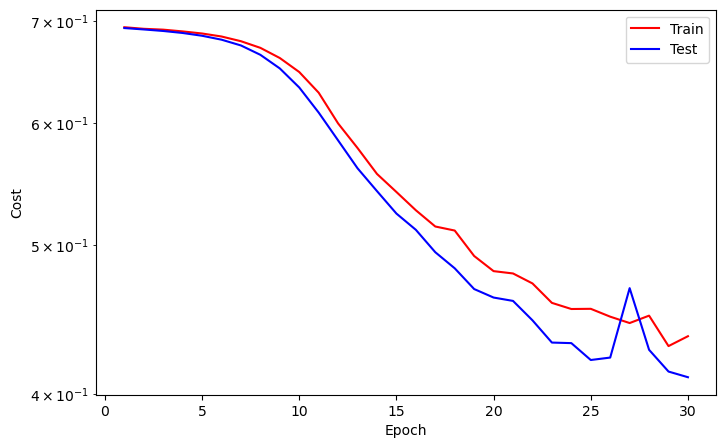

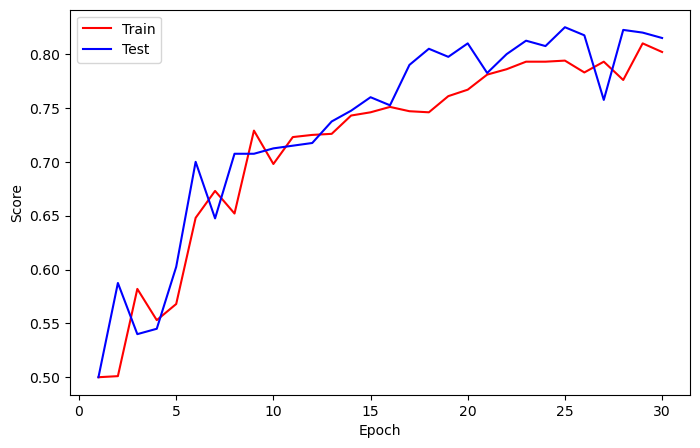

In [23]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
    
    # Loggin
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict 

In [24]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [25]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0])

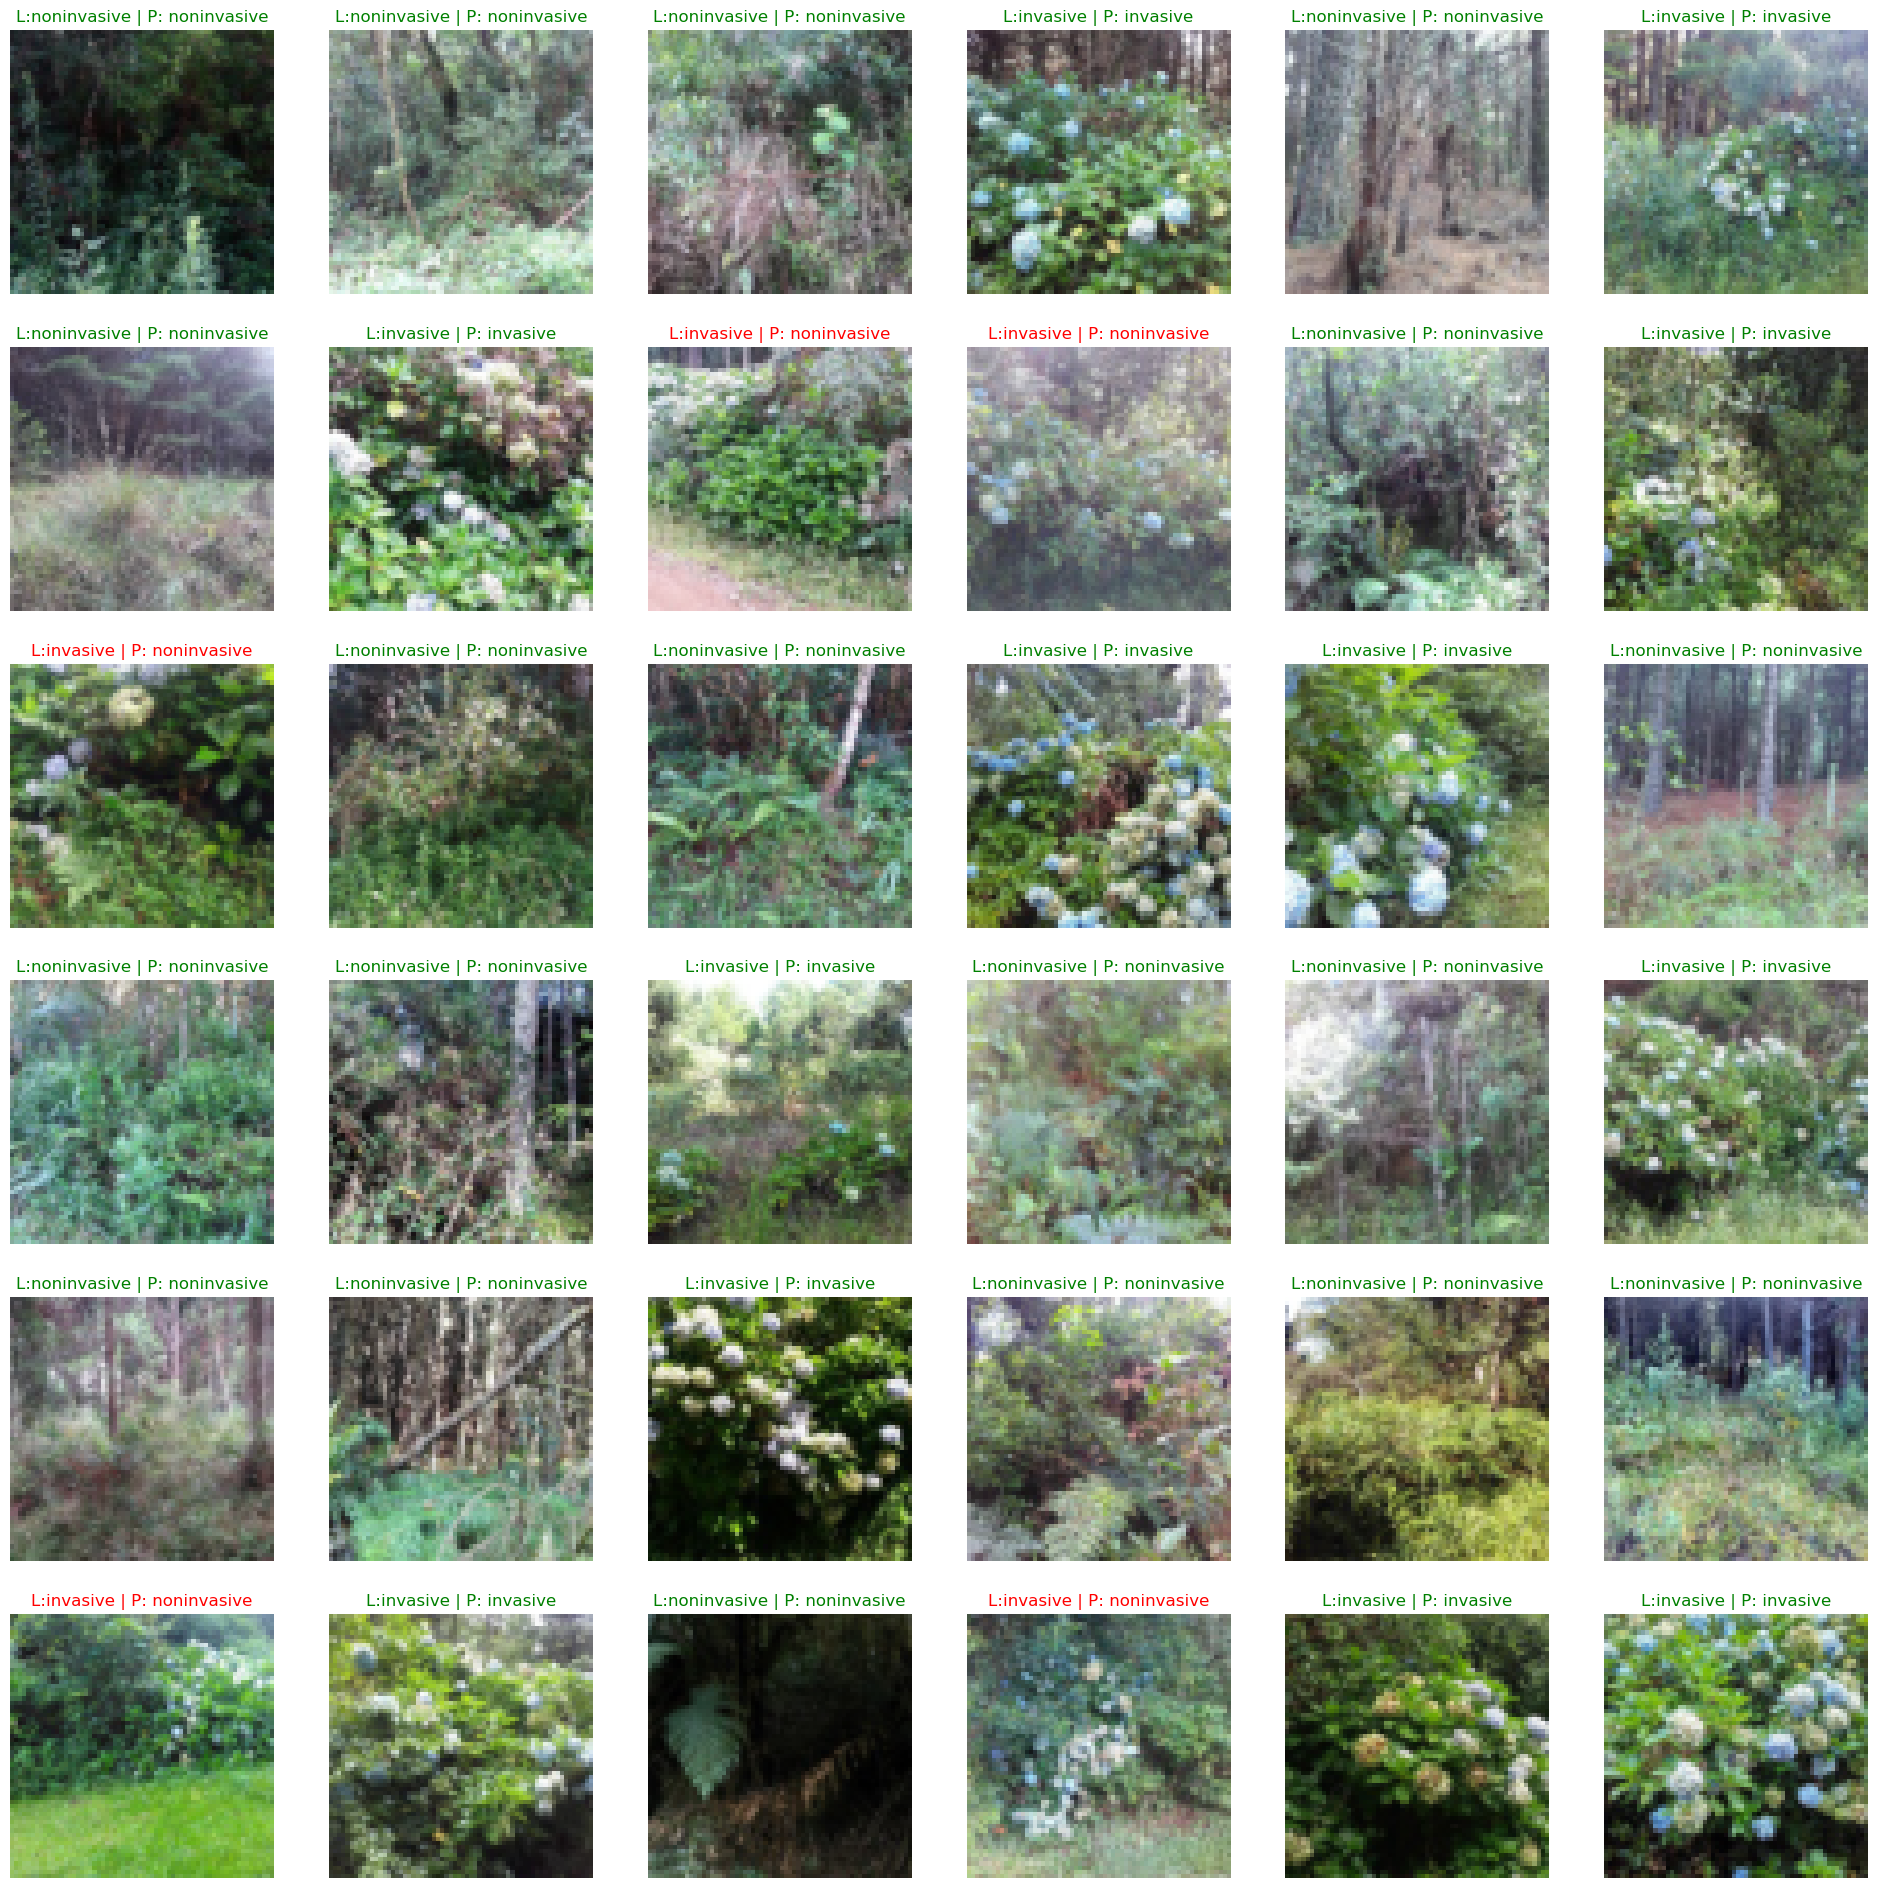

In [26]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1,2,0).cpu())
    font = {'color':'r'} if label != pred else {'color': 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'L:{label} | P: {pred}', fontdict=font);
    ax.axis('off');